### Скачаем дополнительные библиотеки

In [1]:
# %%capture
# !git clone https://github.com/SalesforceAIResearch/uni2ts.git
# !pip install workalendar
# pip install lightgbm

#### Импортируем все библиотеки, которые понадабятся далее для работы

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Основные библиотеки для работы с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Метрики и модели sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# GluonTS компоненты
from gluonts.dataset.repository import dataset_recipes
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

# Uni2ts компоненты
from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_next_multi, plot_single
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

# Календарь и работа с датами
import time
from workalendar.europe import Russia
from datetime import date, timedelta

# LightGBM
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from datetime import timedelta
from workalendar.europe import Russia

#### Считаем все данные

In [3]:
path = 'data/'  # поменять на свой path
data1 = pd.read_csv(path + 'data1.csv')
data2 = pd.read_csv(path + 'data2.csv')
data3 = pd.read_csv(path + 'data3.csv')
data4 = pd.read_csv(path + 'data4.csv')
data5 = pd.read_csv(path + 'data5.csv')

#### Преобразуем даты в datetime для всех датасетов

In [4]:
for i in range(1, 6):
    data = eval(f'data{i}')
    data['date'] = pd.to_datetime(data['date'])

#### Посмотрим какие периоды мы имеем

In [5]:
for i in range(1, 6):
    data = eval(f'data{i}')
    print(f"Датасет {i}:")
    print(data['date'].head(1).iloc[0])
    print(data['date'].tail(1).iloc[0])
    print("" + "-" * 30)

Датасет 1:
2022-01-01 00:00:00
2024-08-31 00:00:00
------------------------------
Датасет 2:
2022-01-01 00:00:00
2024-08-31 00:00:00
------------------------------
Датасет 3:
2022-01-01 00:00:00
2024-08-31 00:00:00
------------------------------
Датасет 4:
2022-01-01 00:00:00
2024-07-31 00:00:00
------------------------------
Датасет 5:
2022-08-01 00:00:00
2023-07-31 00:00:00
------------------------------


#### Начало даты и конец даты
1) 2022.январь -> 2024.август
2) 2022.январь -> 2024.август
3) 2022.январь -> 2024.август
4) 2022.январь -> 2024.июль
5) 2022.август -> 2024.июль

---
### Посмотрим данные на NaN

In [6]:
for i in range(1, 6):
    data = eval(f'data{i}')
    print(str(i) + ')')
    print(data.isna().sum().to_string())
    print('---------------')

1)
value    0
date     0
---------------
2)
value    1
date     0
---------------
3)
value    6
date     0
---------------
4)
date     0
value    0
---------------
5)
date     0
value    0
---------------


У нас 1 пропущенное значение в data2 и 6 пропущенных значений в data3

Это получается нам надо спрогнозировать пропущенные значения, чтобы спрогнозировать следующий месяц, интересно

In [7]:
for i in range(2, 4):
    data = eval(f'data{i}')
    print(f"Датасет {i}:")
    missing_rows = data[data['value'].isna()]
    if len(missing_rows) > 0:
        print(missing_rows[['date', 'value']].to_string())
    print('---------------')

Датасет 2:
          date  value
425 2023-03-02    NaN
---------------
Датасет 3:
          date  value
673 2023-11-05    NaN
674 2023-11-06    NaN
682 2023-11-14    NaN
767 2024-02-07    NaN
952 2024-08-10    NaN
953 2024-08-11    NaN
---------------


#### Рассмотрим data2 в предыдущем году и нынешнем году

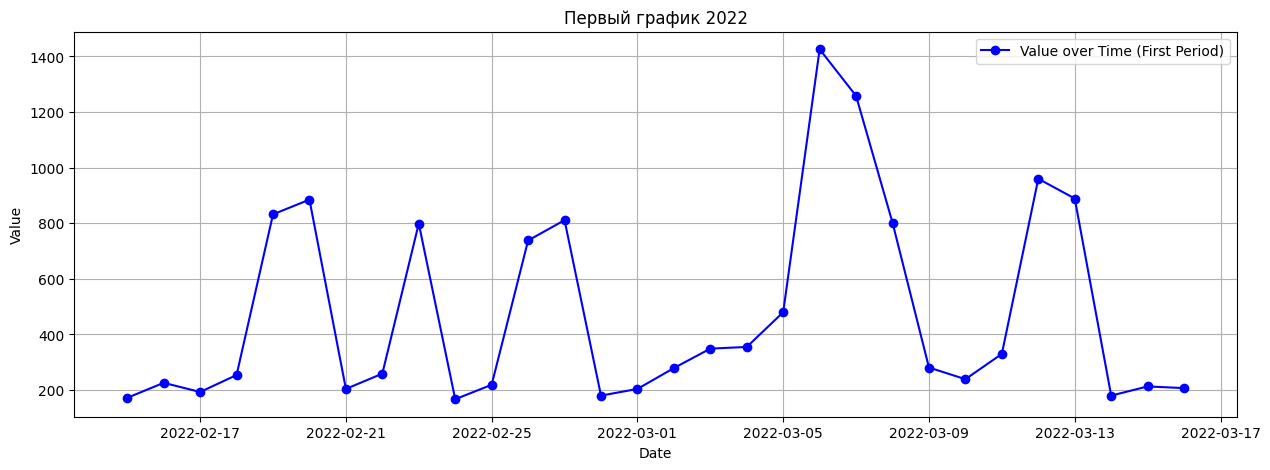

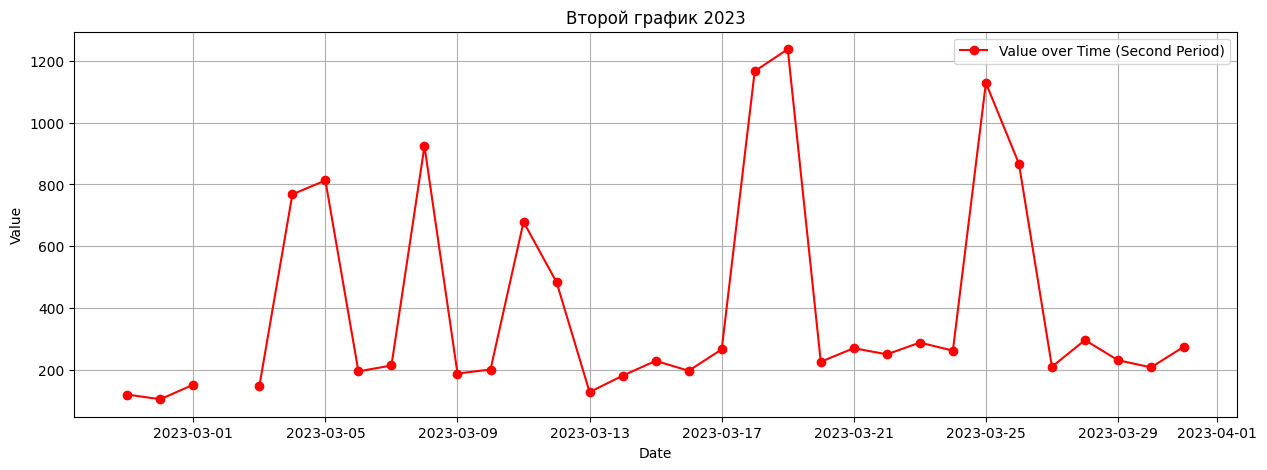

In [8]:
# Первый график
plt.figure(figsize=(15, 5))
plt.plot(data2[45:75]['date'], data2[45:75]['value'], marker='o', linestyle='-', color='b', label='Value over Time (First Period)')
plt.title("Первый график 2022")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

# Второй график
plt.figure(figsize=(15, 5))
plt.plot(data2[57+365:90+365]['date'], data2[57+365:90+365]['value'], marker='o', linestyle='-', color='r', label='Value over Time (Second Period)')
plt.title("Второй график 2023")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()


Можно сделать вывод, что на 23 февраля и на 8 марта происходят закупки, а между этими датами данные обычные в зависимости от дня недели.

Заполним пропущенные значения в data2 средним значением предыдущего дня и следующего дня.


In [9]:
data2.iloc[425, 0] = (data2.iloc[424]['value'] + data2.iloc[426]['value']) / 2
data2.iloc[425, 0]

150.5

#### Рассмотрим data3

![im.png](https://i.imgur.com/BT2T4lV.png)

По этим графикам можно заметить что 5 число вс, а 6 пн. По тренду можно заметить, что в вск значение меньше суботы, а в пн еще меньше. Присвоим значения ручками.

14 число это вт, там обычные данные, можно взять вообще срднее значение предыдущего и следующего дня

In [10]:
data3.iloc[673, 0] = 250
data3.iloc[674, 0] = 230

data3.iloc[682, 0] = (data3.iloc[682-1]['value'] + data3.iloc[682+1]['value']) / 2

data3.iloc[673, 0], data3.iloc[674, 0], data3.iloc[682, 0]

(250.0, 230.0, 242.5)

Так, мы посмотрели 3 предыдущие значения, теперь посмотрим следующий один и еще два последних (767, 952, 953)

![im.png](https://i.imgur.com/jX5u6hk.png)

Здесь ничего особенного не выделишь, тк будний день. Возьмем среднее значение предыдущего дня и следующего.

In [11]:
data3.iloc[767, 0] = (data3.iloc[767-1]['value'] + data3.iloc[767+1]['value']) / 2
data3.iloc[767, 0]

173.0

Два последних nan`a попались на субботу и воскресенье

![im.png](https://i.imgur.com/FP6UNSy.png)

Т.к. это суббота и воскресенье поставим большие данные на субботу, а для вск возьмем среднее

In [12]:
data3.iloc[952, 0] = 335
data3.iloc[953, 0] = (data3.iloc[953-1]['value'] + data3.iloc[953+1]['value']) / 2

data3.iloc[952, 0], data3.iloc[953, 0]

(335.0, 316.0)

Приведём все таблицы в один вид (столбцы target, date)

In [13]:
 # Переименовываем столбцы для всех датасетов
for i in range(1, 6):
    data = eval(f'data{i}')
    # Переименовываем 'value' в 'target'
    data = data.rename(columns={'value': 'target'})
    # Переупорядочиваем столбцы
    data = data[['target', 'date']]
    # Сохраняем обратно в переменную
    globals()[f'data{i}'] = data

### Теперь из столбца date выделим дополнительные признаки, например праздники, выходные и тд

1) Создадим массив в котором будут выходные даты, достанем их из производственного календаря

In [14]:
cal = Russia()
weekends = set()

# Проходим по всем датам с 2022 по 2024
for year in range(2022, 2025):
    for month in range(1, 13):
        days_in_month = pd.Period(f'{year}-{month}').days_in_month
        
        for day in range(1, days_in_month + 1):
            current_date = date(year, month, day)
            
            # Если день не рабочий (выходной или праздник), добавляем его в список
            if not cal.is_working_day(current_date):
                weekends.add(current_date)

2. Добавим даты праздников и для некоторых за три дня даты

In [15]:
# Функция для добавления праздника и дней перед ним
def add_holiday_and_before(year, month, day, delta=0):
    holiday_date = date(year, month, day)
    holidays.add(holiday_date)
    
    # Если нужно добавить предпраздничные дни
    if delta:
        for i in range(1, delta):
            before_date = holiday_date - timedelta(days=i)
            holidays.add(before_date)


holidays = set()
for year in range(2022, 2025):
    # Новый год
    add_holiday_and_before(year, 1, 1, 5)

    # День Святого Валентина
    add_holiday_and_before(year, 2, 14)

    # 23 февраля
    add_holiday_and_before(year, 2, 23, 3)

    # 8 марта
    add_holiday_and_before(year, 3, 8, 3)

    # Майские праздники
    add_holiday_and_before(year, 5, 1, 3)
    add_holiday_and_before(year, 5, 9, 3)
    # День России
    add_holiday_and_before(year, 6, 12)

    # 1 сентября
    add_holiday_and_before(year, 9, 1, 3)

    # День народного единства
    add_holiday_and_before(year, 11, 4)

Делаем препроцессинг

In [16]:
def preprocess_data(data, holidays, weekends):

    if 'date' in data.columns:
        data['time'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d 00:00:00')
    
    # Преобразование столбца
    if not isinstance(data.index, pd.DatetimeIndex):
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)

    # День недели, месяц
    data['day_of_week'] = data.index.dayofweek  # Понедельник=0, Воскресенье=6
    data['month'] = data.index.month


    data['season'] = data['month'].apply(lambda x: 1 if x in [12, 1, 2]  # зима
                                         else 2 if x in [3, 4, 5]     # весна
                                         else 3 if x in [6, 7, 8]     # лето
                                         else 4)                       # осень
    
    # Дни до ближайшего праздника
    data['is_holiday'] = data.index.to_series().apply(lambda x: 1 if x.date() in holidays else 0)
    data['is_weekend'] = data.index.to_series().apply(lambda x: 1 if x.date() in weekends else 0)

    data['date'] = pd.to_datetime(data['time']).dt.strftime('%Y-%m-%d 00:00:00')
    data.set_index('date', inplace=True)
    return data

Применяем нашу функцию ко всем data

In [17]:
for i in range(1, 6):
    data = eval(f'data{i}')
    globals()[f'data{i}'] = preprocess_data(data, holidays, weekends)

Добавляем тренды за 30 дней и за 7 дней, сначала напишем функцию

In [18]:
def add_trend_columns(data, window_30=30, window_7=7):
    # Существующие тренды
    data['trend_90'] = data['target'].rolling(window=90, min_periods=1).mean()
    data['trend_60'] = data['target'].rolling(window=60, min_periods=1).mean()
    data['trend_30'] = data['target'].rolling(window=window_30, min_periods=1).mean()
    data['trend_7'] = data['target'].rolling(window=window_7, min_periods=1).mean()
    
    return data

In [19]:
for i in range(1, 6):
    data = eval(f'data{i}')
    globals()[f'data{i}'] = add_trend_columns(data)

In [20]:
# Готовим данные для Moirai MOE

for i in range(1, 6):
    data = eval(f'data{i}')
    
    # Получаем начальную дату и количество периодов для каждого датасета
    start_date = data.index[0]
    periods = len(data)
    
    # Создаем временной индекс для каждого датасета
    date_range = pd.date_range(start=start_date, periods=periods, freq='D')
    
    # Присваиваем новый индекс
    data.index = date_range
    
    # Удаляем столбец time если он существует
    if 'time' in data.columns:
        data.drop(columns=['time'], inplace=True)
    
    # Сохраняем обратно в переменную
    globals()[f'data{i}'] = data

#### Функция для визуализирования валидации

In [21]:
def plot_actual_predict(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    
    # Создаем массив индексов для оси X
    x = np.arange(len(y_test))
    
    # Строим графики
    plt.plot(x, y_test, label='Actual', color='blue')
    plt.plot(x, y_pred, label='Predicted', color='orange', linestyle='--')
    plt.fill_between(x, y_test, y_pred, color='gray', alpha=0.2, label='Error')
    
    # Настраиваем внешний вид
    plt.legend()
    plt.grid(True)
    plt.title('Actual vs Predicted')
    plt.xlabel('Days')
    plt.ylabel('Value')
    
    # Добавляем значения на график
    for i, (actual, pred) in enumerate(zip(y_test, y_pred)):
        plt.annotate(f'{actual:.0f}', (i, actual), textcoords="offset points", 
                    xytext=(0,-15), ha='center')
        plt.annotate(f'{pred:.0f}', (i, pred), textcoords="offset points", 
                    xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Выводим метрики
    print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')
    print(f'R2 Score: {r2_score(y_test, y_pred):.2f}')

# Обучение и предсказание на 30 последних дней двух моделей

### Возьмем первым lightgbm

Создадим функцию препроцессинга и создания фичей

In [22]:
# создадим функцию предобработки данных
def preprocess_data_with_holidays_and_nearby(data, test_size):
    
    # === Разделение на обучающую и тестовую выборки ===
    train, test = data[:-test_size].copy(), data[-test_size:].copy()
    
    # Лаги (значения на предыдущих шагах)
    for lag in range(1, 8):  # Создаем лаги за последние 7 дней
        train[f'lag_{lag}'] = train['target'].shift(lag)

    for lag in range(1, 8):  # Создаем лаги за последние 7 дней
        train[f'lag_{lag}'] = train[f'lag_{lag}'].replace(0, train[f'lag_{lag}'].mean())

    # Скользящее среднее
    train['rolling_mean_7'] = train['target'].rolling(window=7).mean()
    train['rolling_mean_30'] = train['target'].rolling(window=30).mean()

    X_train, y_train = train.drop(columns=['target']), train['target']
    X_test, y_test = test.drop(columns=['target']), test['target']

    return X_train, X_test, y_train, y_test


#функция добавления лагов и скользящего окна во время предсказаний
def create_features(history, lag_range=7):
    features = {}
    for lag in range(1, lag_range + 1):
        # Используем iloc для позиционной индексации
        features[f'lag_{lag}'] = history[-lag] if len(history) >= lag else np.nan
    features['rolling_mean_7'] = np.mean(history[-7:]) if len(history) >= 7 else np.nan
    features['rolling_mean_30'] = np.mean(history[-30:]) if len(history) >= 30 else np.nan
    return features

Зададим функцию предсказаний модели

In [23]:
#зададим функцию предсказаний модели
def stepwise_prediction_lgb(model, X_test, history, lag_range=7):
    predictions = []

    # Проходим по каждому шагу в тестовом наборе
    for i in range(len(X_test)):
        # Создаем копию текущей строки X_test, чтобы не изменять оригинальные данные
        current_row = X_test.iloc[i].copy()
        
        # Создаем новые признаки из текущей истории
        new_features = create_features(history, lag_range=lag_range)

        # Добавляем новые признаки к текущей строке
        for feature_name, value in new_features.items():
            current_row[feature_name] = value

        # Заполняем пропуски медианой (учитывая предыдущие строки)
        current_row = current_row.fillna(X_test.iloc[:i].median())

        # Предсказание для текущей строки
        prediction = model.predict(current_row.to_numpy().reshape(1, -1))
        predictions.append(prediction[0])  # Если модель возвращает массив, берем первый элемент

        # Добавляем предсказание в историю для следующего шага
        history.append(prediction[0])

    return predictions

Поиск гиперпараметров и предсказывания на валидации

In [24]:
def train_test_randomized_search(data, test_size):
    param_dist = {
        'n_estimators': [100, 250, 500, 1000],  # Количество деревьев
        'learning_rate': [0.01, 0.025, 0.05, 0.1],  # Скорость обучения
        'max_depth': [3, 5, 7],  # Глубина деревьев
        'num_leaves': [20, 31, 40, 50],  # Количество листьев в дереве
        'subsample': np.linspace(0.6, 1.0, 5),  # Часть выборки для каждого дерева
        'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Часть признаков для каждого дерева
    }
    
    # Модель LightGBM
    model = lgb.LGBMRegressor(random_state=42)
    
    #RandomizedSearchCV с кросс-валидацией
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=60,  # Количество случайных комбинаций для поиска
        cv=5,  # 4-кратная кросс-валидация
        scoring='neg_mean_squared_error',  # Оценка по метрике MSE
        verbose=1,  # Вывод информации о процессе
        n_jobs=-1,  # Использование всех ядер процессора
        random_state=42
    )
    
    X_train, X_test, y_train, y_test = preprocess_data_with_holidays_and_nearby(data, test_size)


    # Обучение модели
    random_search.fit(X_train.to_numpy(), y_train.to_numpy())
    
    # Использование модели с лучшими параметрами
    best_model = random_search.best_estimator_
    
    # История состоит из y_train
    history = y_train.tolist()
    
    # Пошаговое предсказание
    y_pred = stepwise_prediction_lgb(best_model, X_test, history, lag_range=7)

    clear_output(wait=True)

    print('Best params:', random_search.best_params_)

    feature_importances = best_model.feature_importances_

    feature_names = X_train.columns

    # Построение графика
    plt.barh(feature_names, feature_importances)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Feature Importances")
    plt.show()
    
    # Оценка и визуализация
    plot_actual_predict(y_test, y_pred)

    return y_pred

1 Датафрейм

Best params: {'subsample': 0.7, 'num_leaves': 40, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.025, 'colsample_bytree': 0.6}


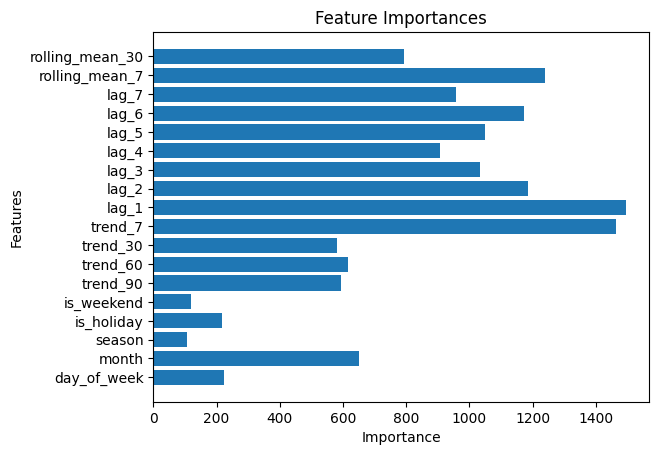

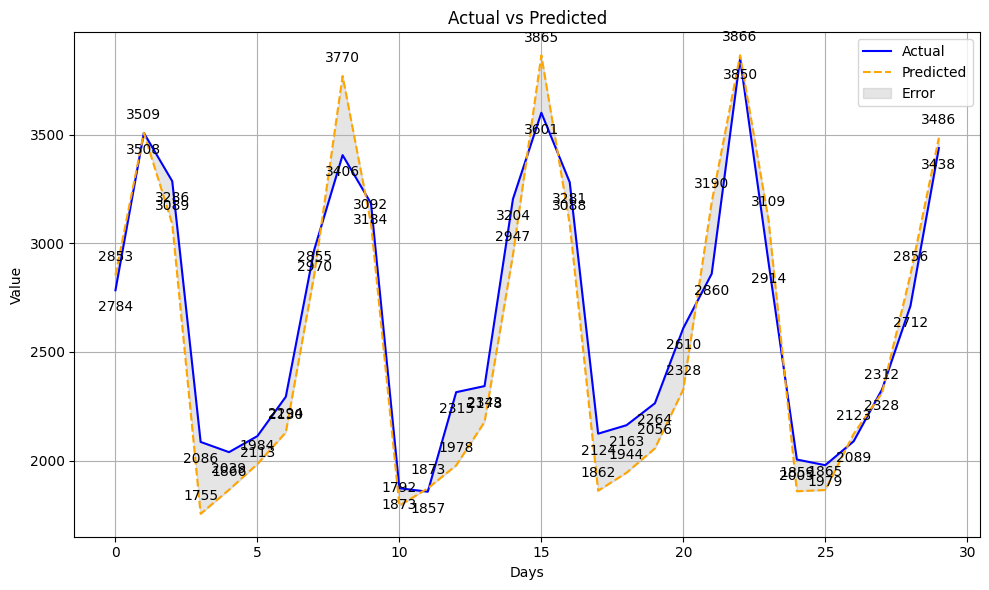

MAE: 165.31
RMSE: 195.46
R2 Score: 0.89


In [25]:
y_pred_lgbm1 = train_test_randomized_search(data1, test_size=30)

2 Датафрейм

Best params: {'subsample': 1.0, 'num_leaves': 40, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.025, 'colsample_bytree': 0.8}


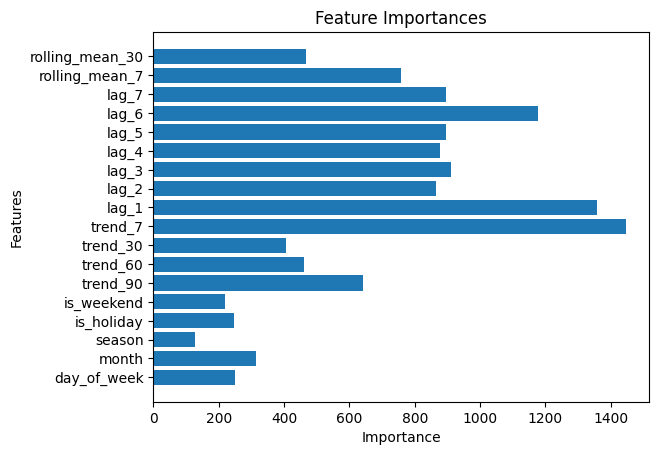

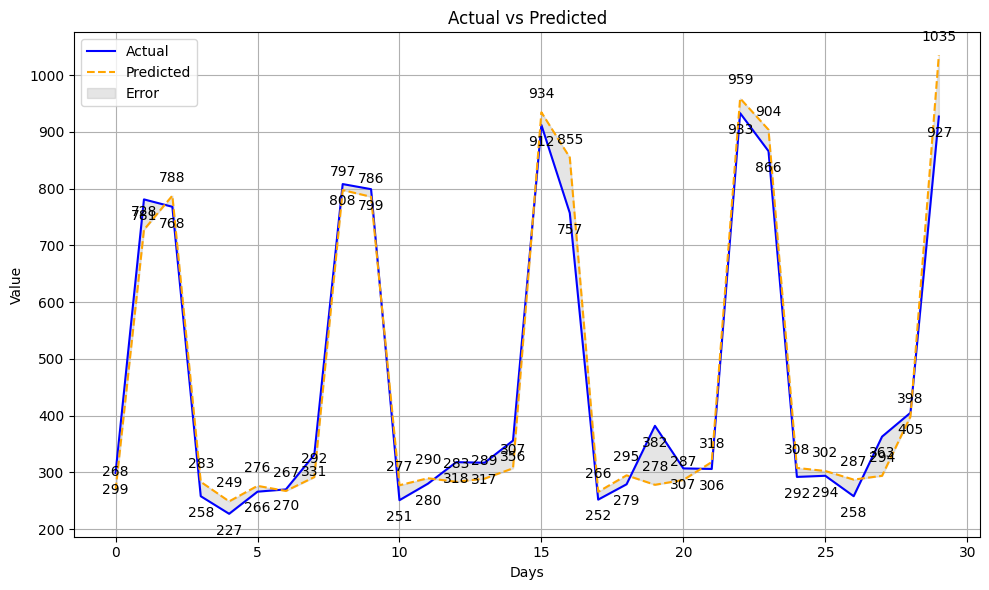

MAE: 32.07
RMSE: 42.44
R2 Score: 0.97


In [26]:
y_pred_lgbm2 = train_test_randomized_search(data2, test_size=30)

3 Датафрейм

Best params: {'subsample': 0.6, 'num_leaves': 50, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


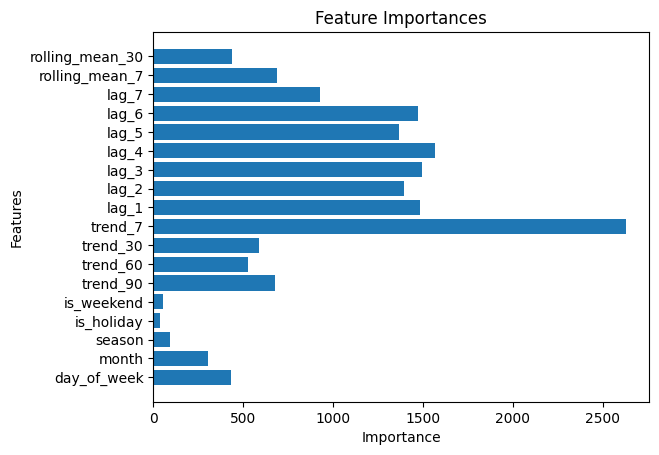

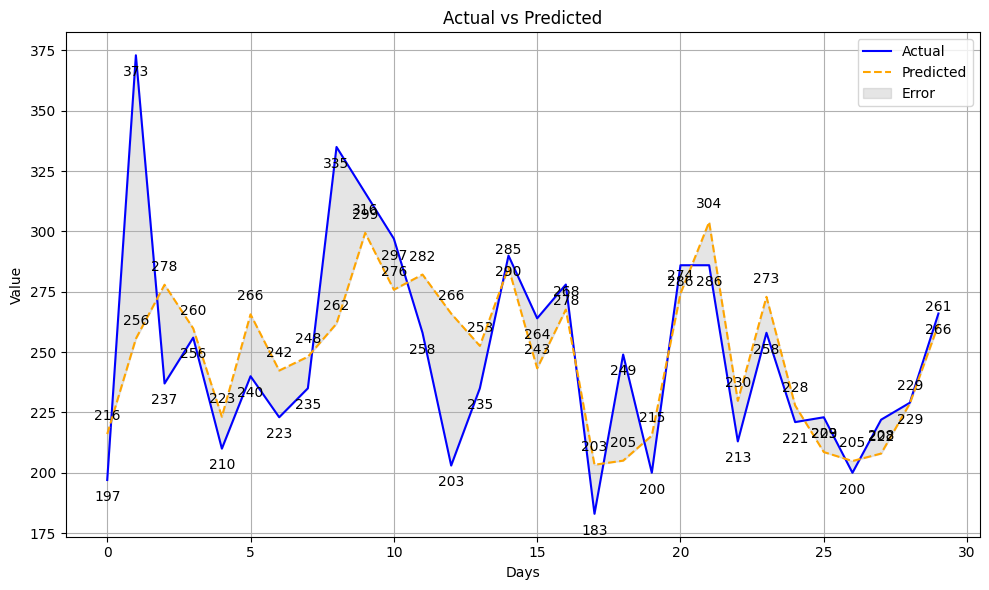

MAE: 23.02
RMSE: 33.05
R2 Score: 0.42


In [27]:
y_pred_lgbm3 = train_test_randomized_search(data3, test_size=30)

4 Датафрейм

Best params: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


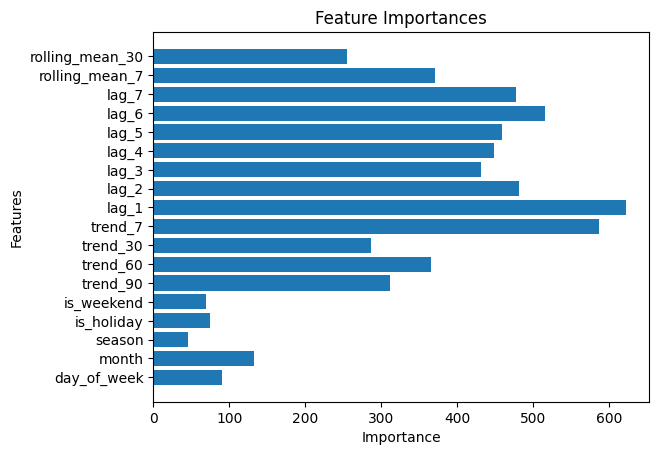

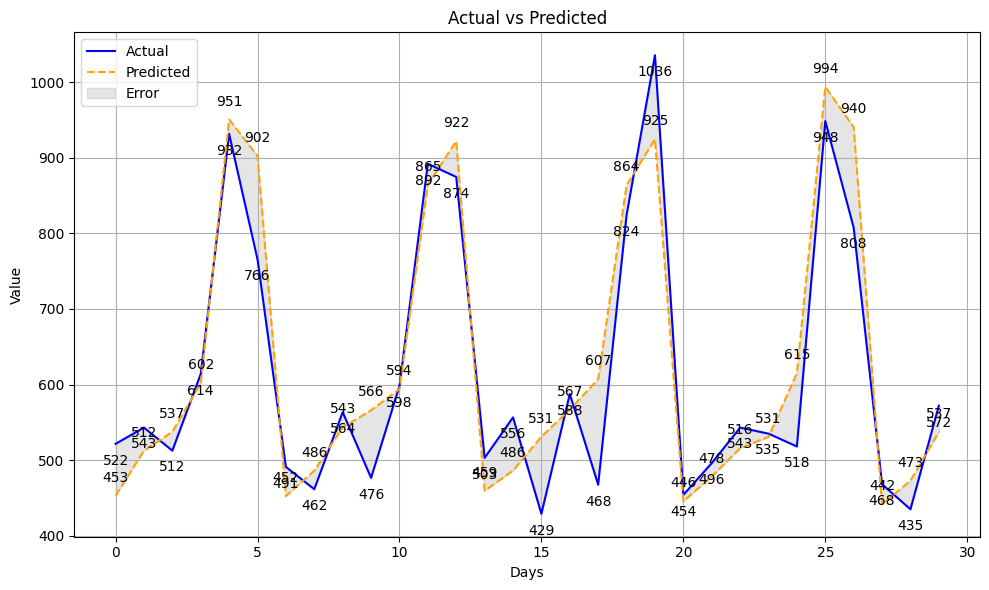

MAE: 50.10
RMSE: 64.23
R2 Score: 0.86


In [28]:
y_pred_lgbm4 = train_test_randomized_search(data4, test_size=30)

5 Датафрейм

Best params: {'subsample': 0.6, 'num_leaves': 40, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


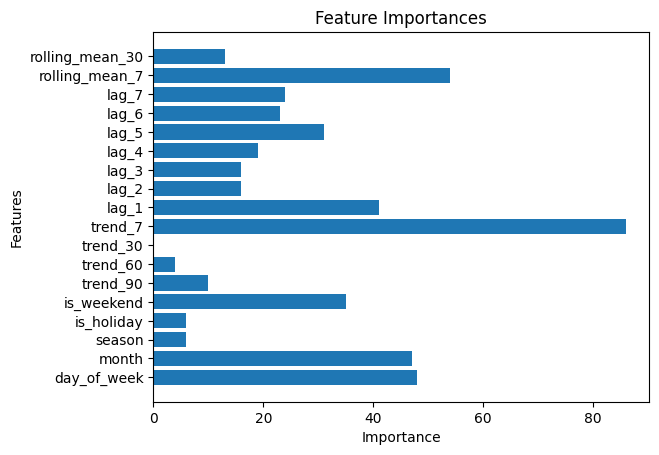

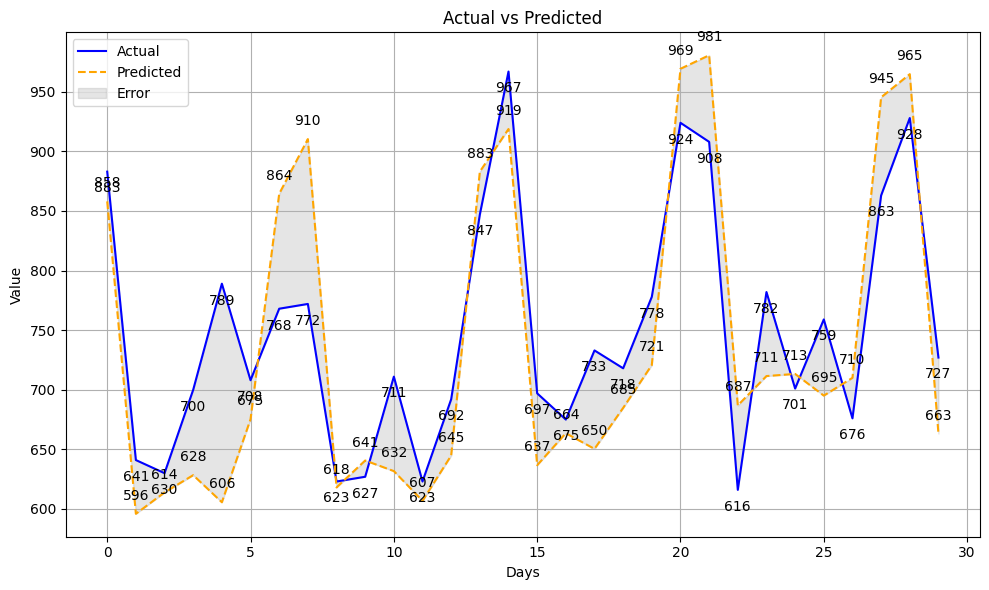

MAE: 55.06
RMSE: 66.76
R2 Score: 0.55


In [29]:
y_pred_lgbm5 = train_test_randomized_search(data5, test_size=30)

In [30]:
data1

,target,day_of_week,month,season,is_holiday,is_weekend,trend_90,trend_60,trend_30,trend_7
2022-01-01,898.0,5,1,1,1,1,898.000000,898.000000,898.000000,898.000000
2022-01-02,3167.0,6,1,1,0,1,2032.500000,2032.500000,2032.500000,2032.500000
2022-01-03,3380.0,0,1,1,0,1,2481.666667,2481.666667,2481.666667,2481.666667
2022-01-04,3423.0,1,1,1,0,1,2717.000000,2717.000000,2717.000000,2717.000000
2022-01-05,3373.0,2,1,1,0,1,2848.200000,2848.200000,2848.200000,2848.200000
...,...,...,...,...,...,...,...,...,...,...
2024-08-27,1979.0,1,8,3,0,0,2710.288889,2647.333333,2559.033333,2640.285714
2024-08-28,2089.0,2,8,3,0,0,2707.422222,2608.400000,2568.333333,2615.285714
2024-08-29,2328.0,3,8,3,0,0,2699.655556,2584.533333,2581.733333,2575.000000
2024-08-30,2712.0,4,8,3,1,0,2684.933333,2599.750000,2606.433333,2553.857143


### Вторым возьмем MoiraiMoe

In [31]:
def pred_moirai(data):
    # Параметры модели
    SIZE = "base"  # размер модели
    PDT = 30  # длина предсказания (30 дней)
    CTX = 100  # длина контекста
    BSZ = 32 # размер батча

    # Загрузка данных
    df = data.copy()

    ds = PandasDataset(dict(df))
    dss = PandasDataset(dict(df[:-PDT]))

    # Разделение на обучающую и тестовую выборки
    train, validation_template = split(ds, offset=-PDT)

    # Генерация тестовых данных
    validation_data = validation_template.generate_instances(
        prediction_length=PDT,
        windows=1,  # одно окно для проверки
        distance=50
    )

    # Загрузка модели
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=dss.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=dss.num_past_feat_dynamic_real,
        
    )

    # Создание предиктора
    predictor = model.create_predictor(batch_size=BSZ)

    # Выполнение предсказаний
    forecasts = predictor.predict(validation_data.input)
    forecast = next(iter(forecasts))

    actual = next(iter(validation_data.label))['target']
    predicted = forecast.mean
    plot_actual_predict(actual, predicted)
    return predicted, actual

Также нарисуем графики, посчитаем метрики и время для каждого запуска

In [32]:
def timed_predictions(data_list):
    results = []
    times = []
    
    for idx, data in enumerate(data_list, start=1):
        start_time = time.time()
        predicted, actual = pred_moirai(data)
        elapsed_time = time.time() - start_time
        
        results.append((predicted, actual))
        times.append(elapsed_time)
        
        print(f"Время выполнения для {idx} датасета: {elapsed_time:.2f} сек.")
    
    return results, times

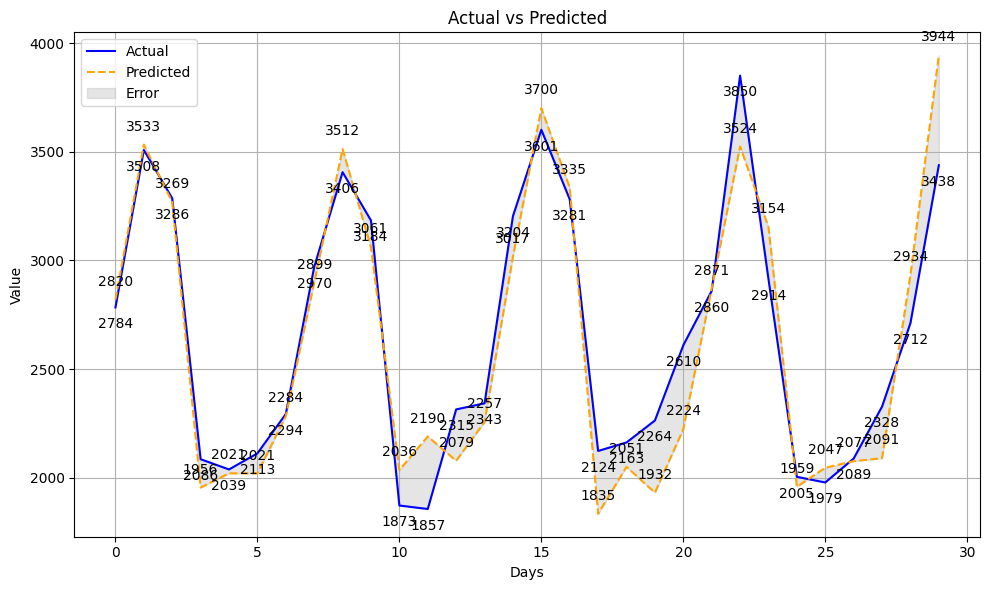

MAE: 152.47
RMSE: 199.63
R2 Score: 0.89
Время выполнения для 1 датасета: 35.17 сек.


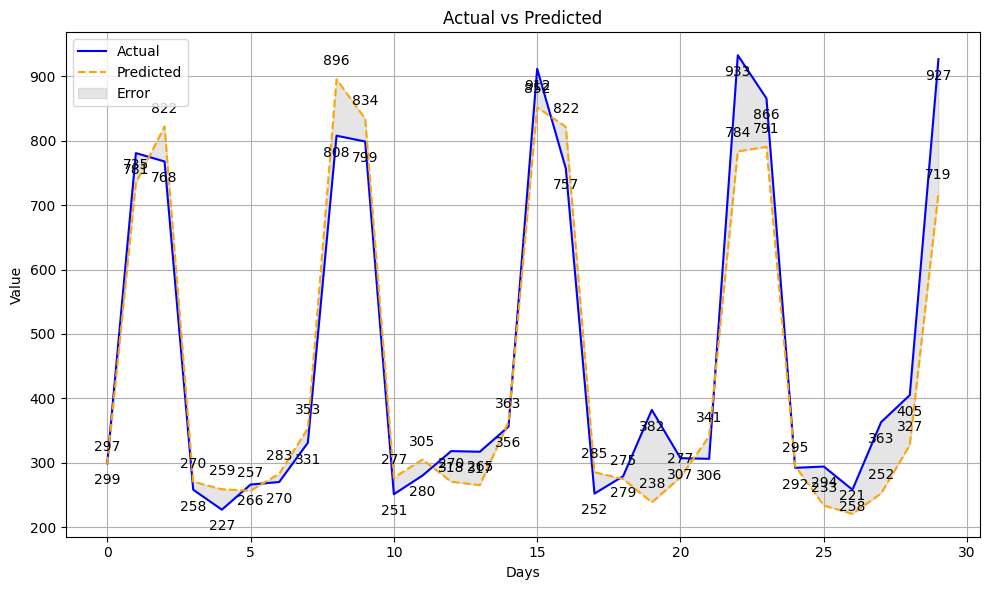

MAE: 52.14
RMSE: 70.37
R2 Score: 0.92
Время выполнения для 2 датасета: 26.67 сек.


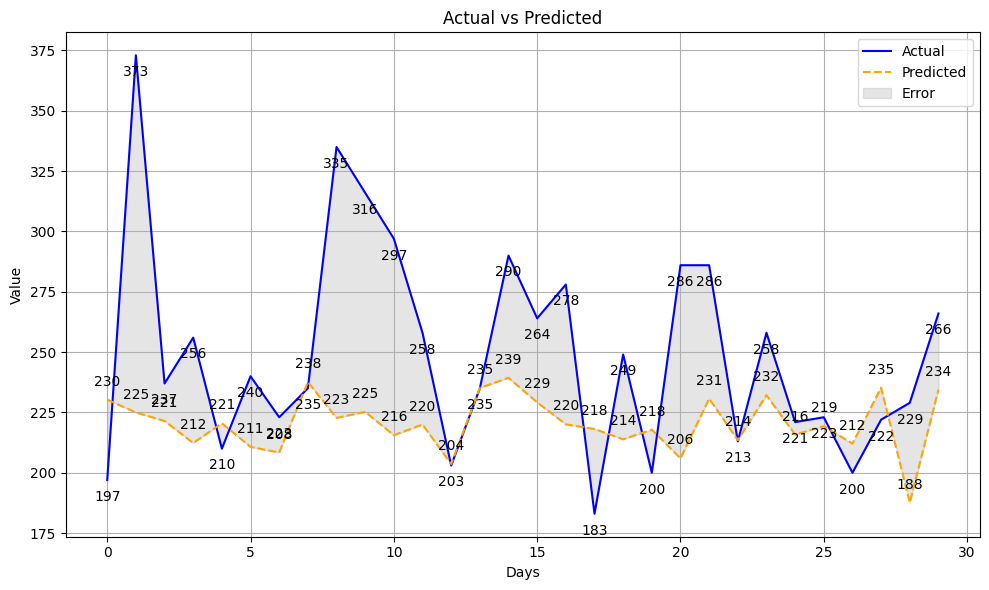

MAE: 37.38
RMSE: 51.12
R2 Score: -0.39
Время выполнения для 3 датасета: 19.21 сек.


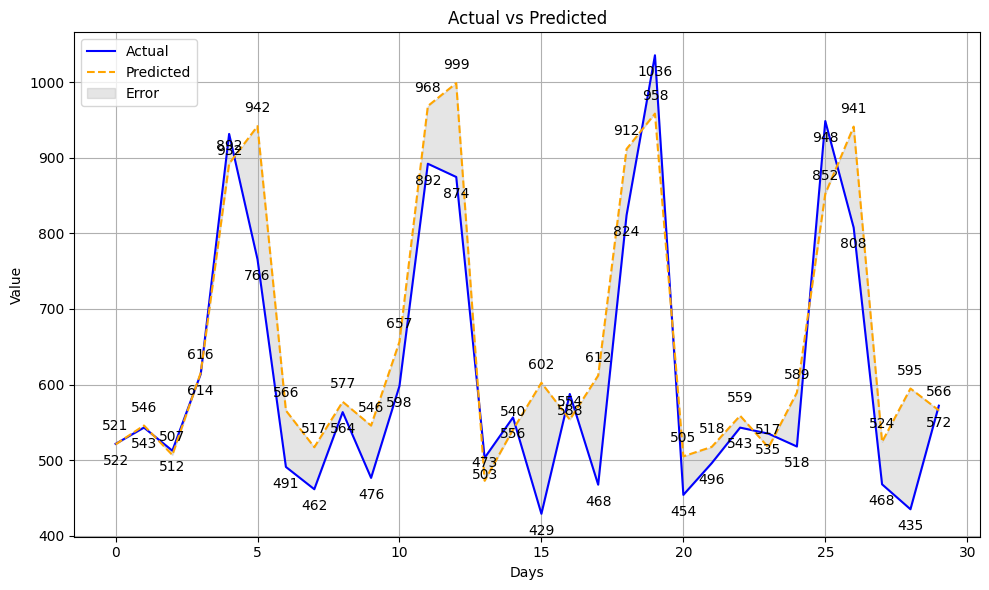

MAE: 63.05
RMSE: 82.13
R2 Score: 0.78
Время выполнения для 4 датасета: 17.30 сек.


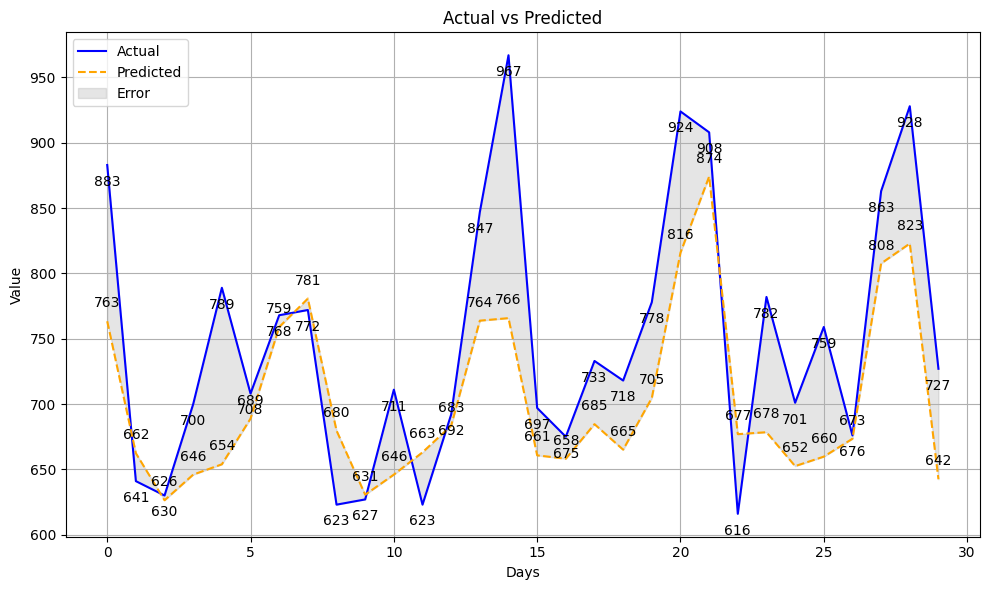

MAE: 58.62
RMSE: 74.36
R2 Score: 0.44
Время выполнения для 5 датасета: 18.06 сек.


In [33]:
data_list = [data1, data2, data3, data4, data5]
results, prediction_times = timed_predictions(data_list)

### Теперь посчитаем средние значения предсказаний двух моделей и посмотрим на них метрики

dataset 1) 174.456895439068


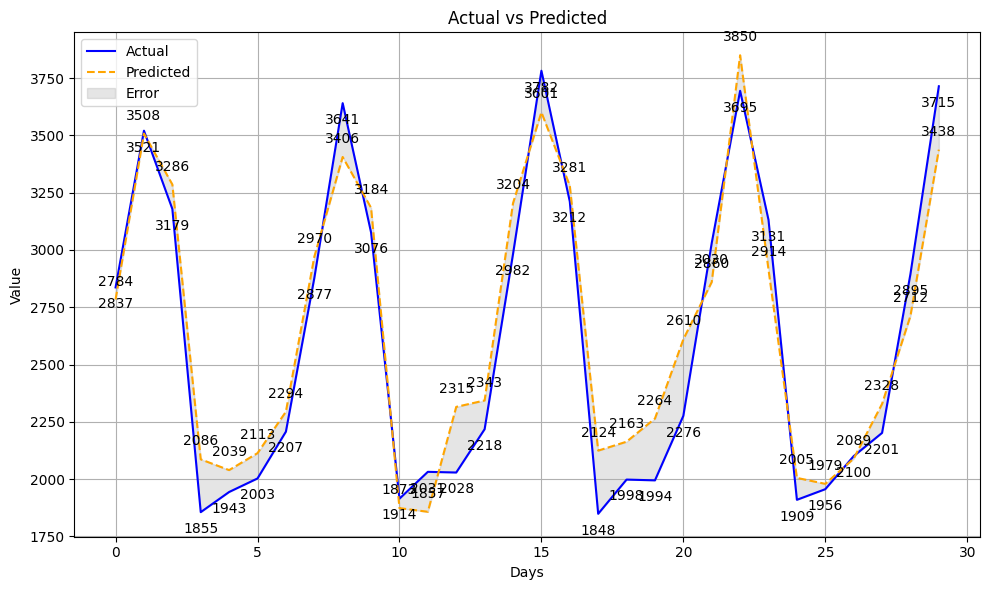

MAE: 151.23
RMSE: 174.46
R2 Score: 0.93
dataset 2) 42.01817865659139


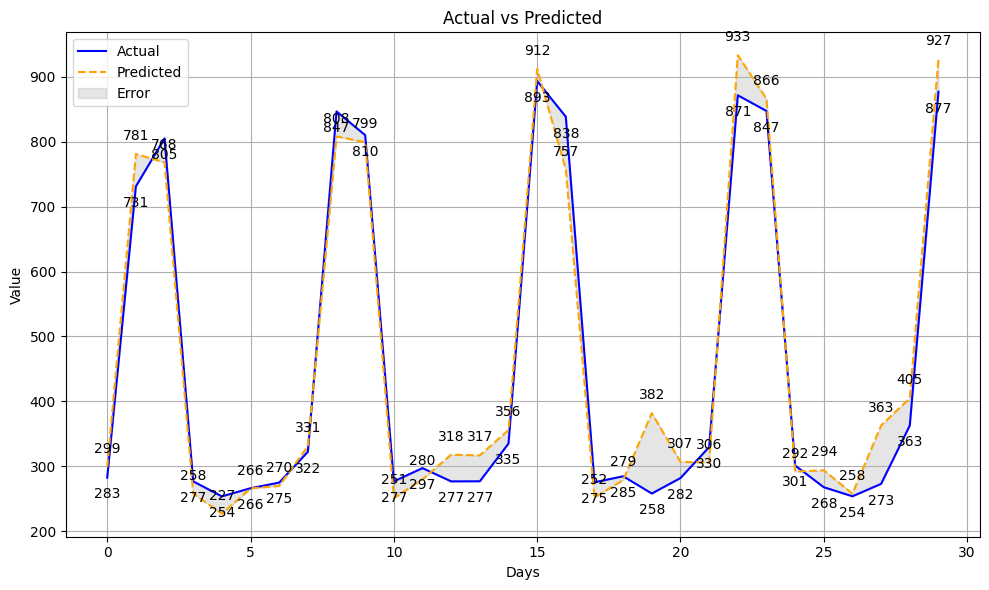

MAE: 32.05
RMSE: 42.02
R2 Score: 0.97
dataset 3) 37.9144004661735


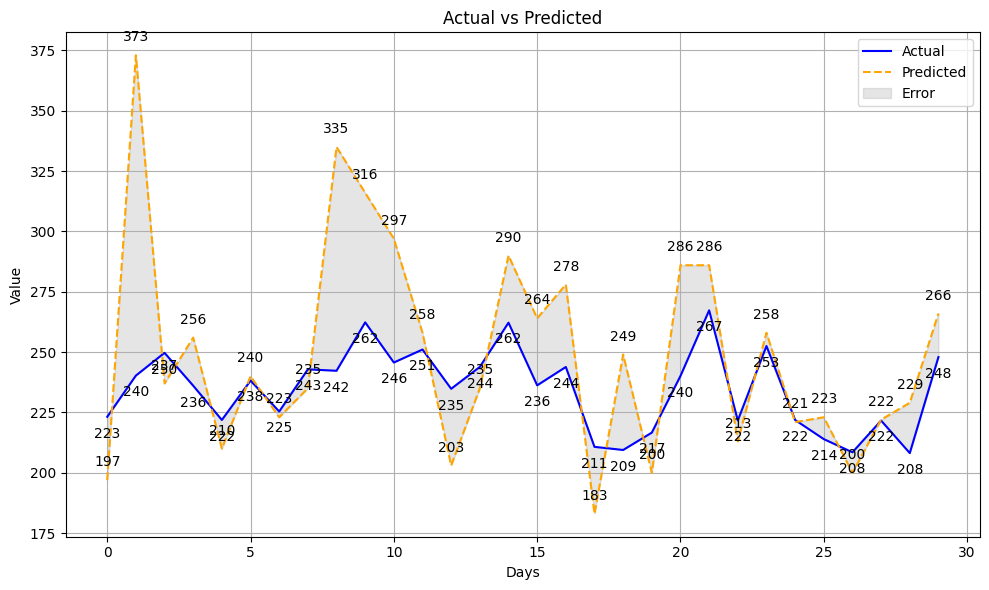

MAE: 25.70
RMSE: 37.91
R2 Score: -4.19
dataset 4) 67.22782935538649


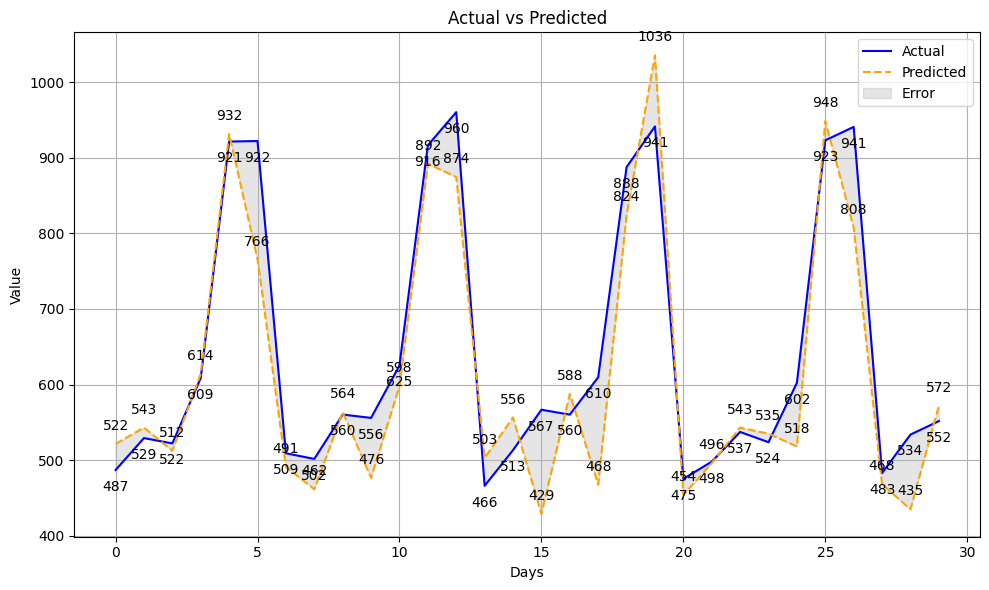

MAE: 49.02
RMSE: 67.23
R2 Score: 0.86
dataset 5) 59.45629171240493


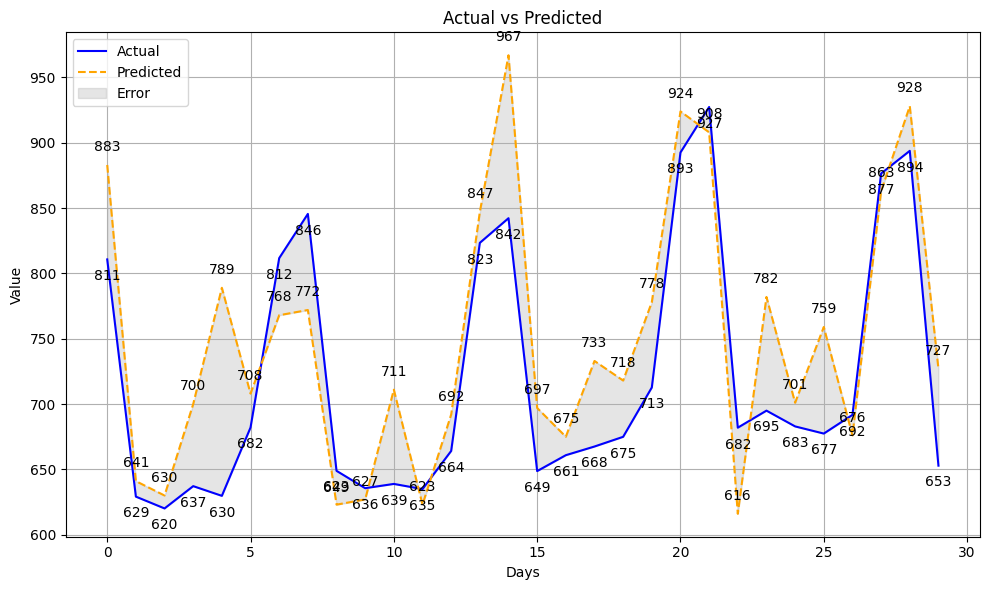

MAE: 47.71
RMSE: 59.46
R2 Score: 0.61


In [34]:
results[0]

for i in range(1, 6):
    y_pred_lgbm = eval(f'y_pred_lgbm{i}')
    y_pred_moiraimoe = eval(f'results[{i-1}][0]')

    actual = eval(f'results[{i-1}][1]')

    mean_val = (np.array(y_pred_lgbm) + y_pred_moiraimoe)/2
    print(f'dataset {i})', mean_squared_error(mean_val, actual)**0.5)
    # plot_actual_predict(mean_val, actual)

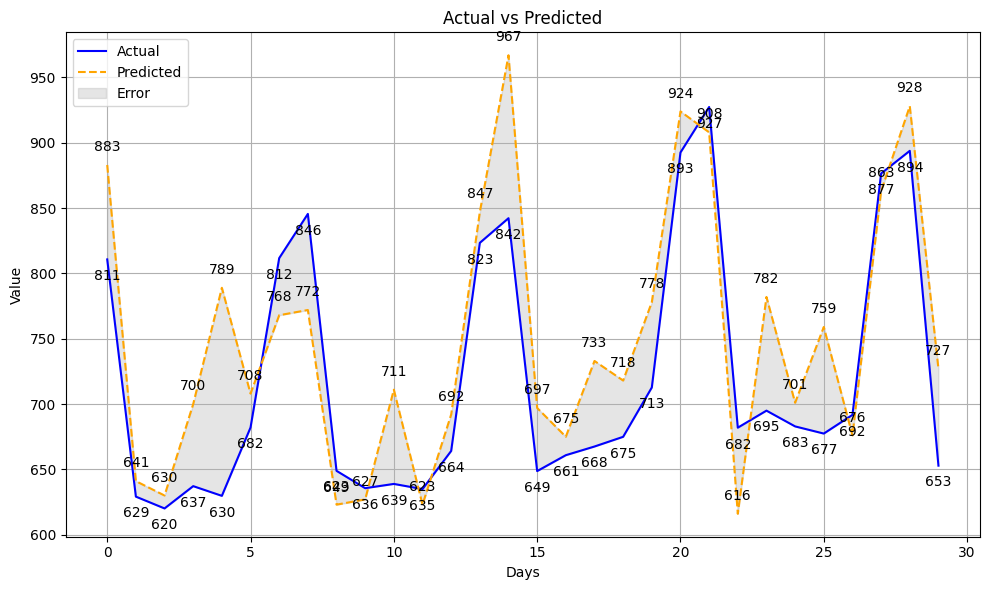

MAE: 47.71
RMSE: 59.46
R2 Score: 0.61


In [35]:
plot_actual_predict(mean_val, actual)

Результаты на метрике RMSE стали лучше

# Предсказаине на следующий месяц

Предсказание на 1 модели


Прогноз для датасета 1:


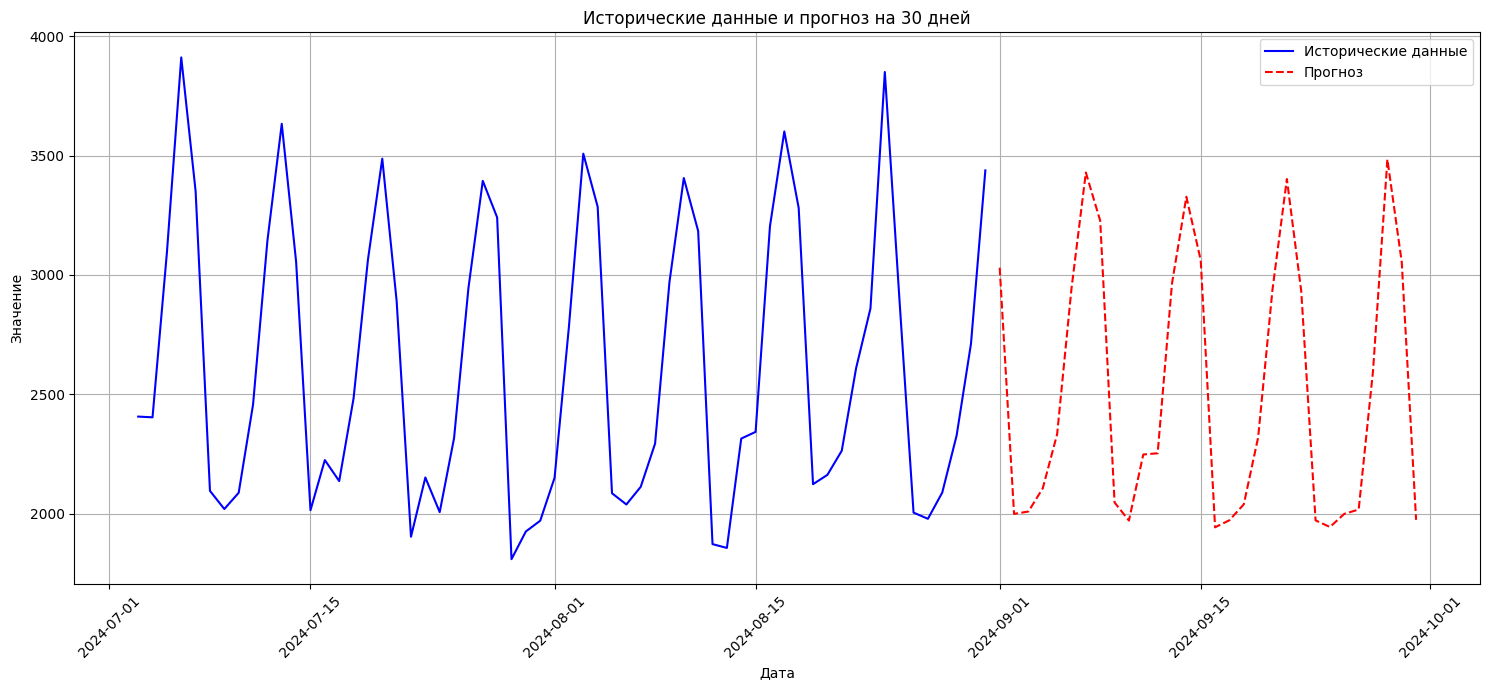


Прогноз для датасета 2:


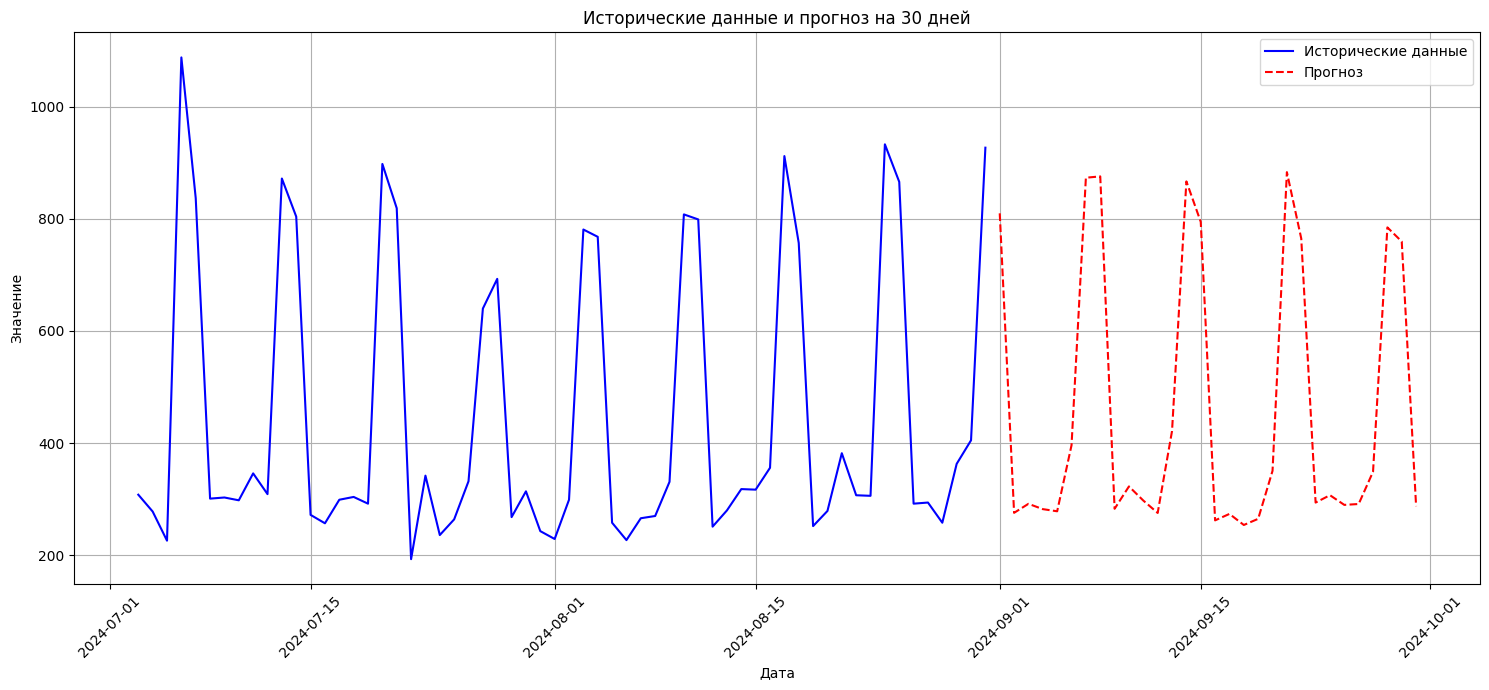


Прогноз для датасета 3:


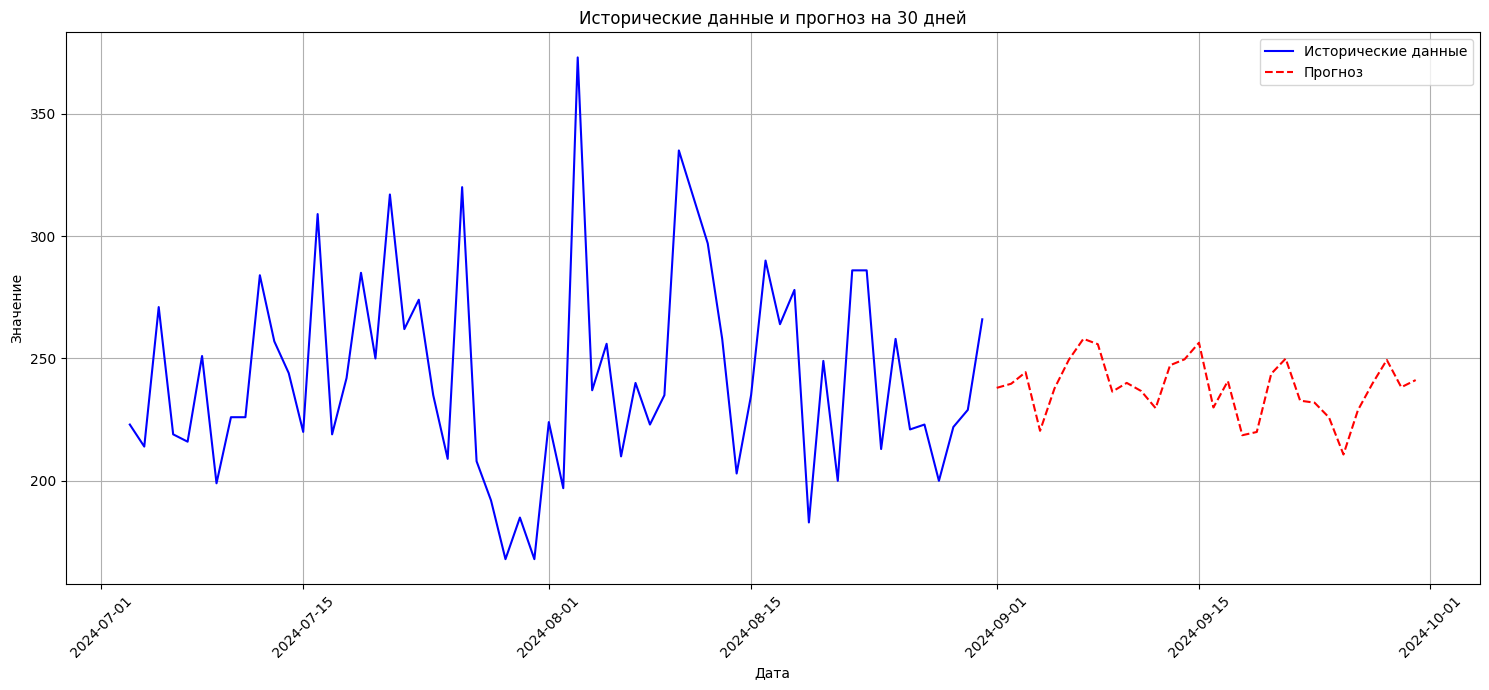


Прогноз для датасета 4:


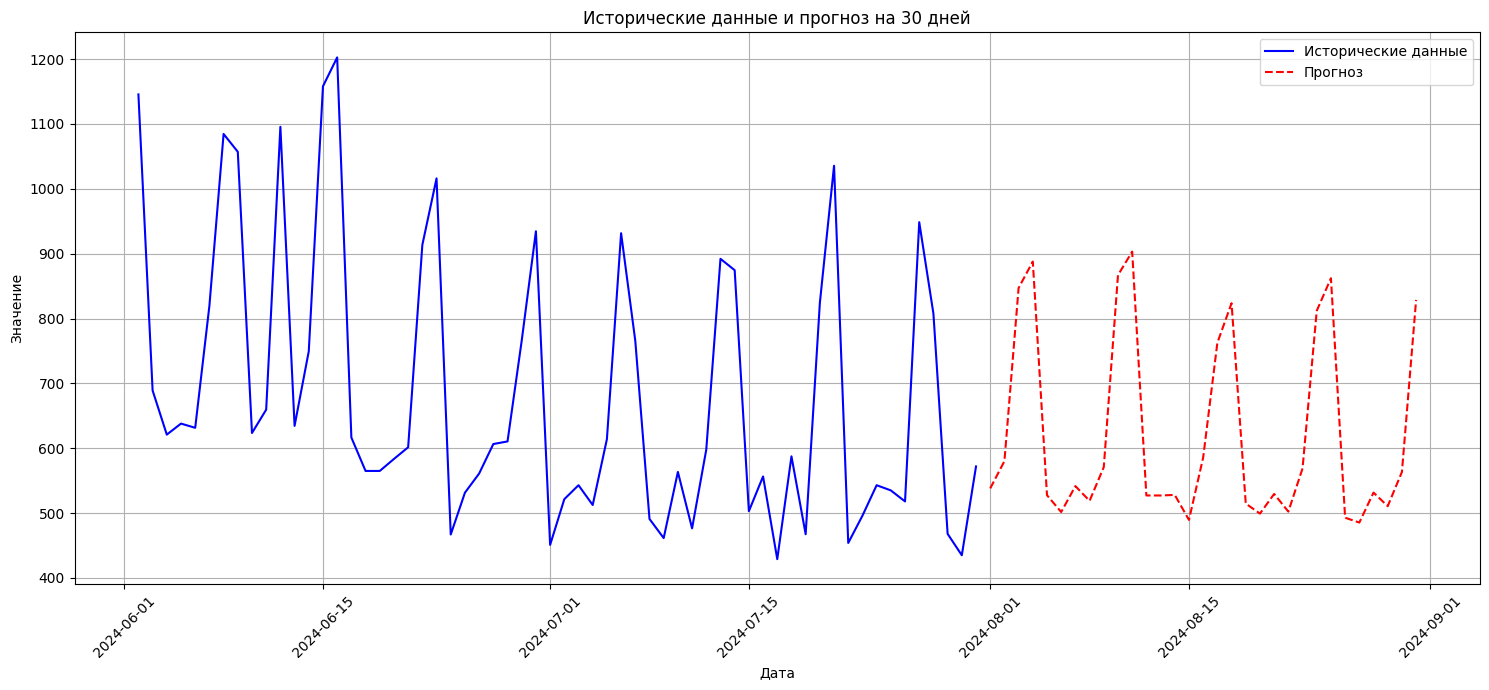


Прогноз для датасета 5:


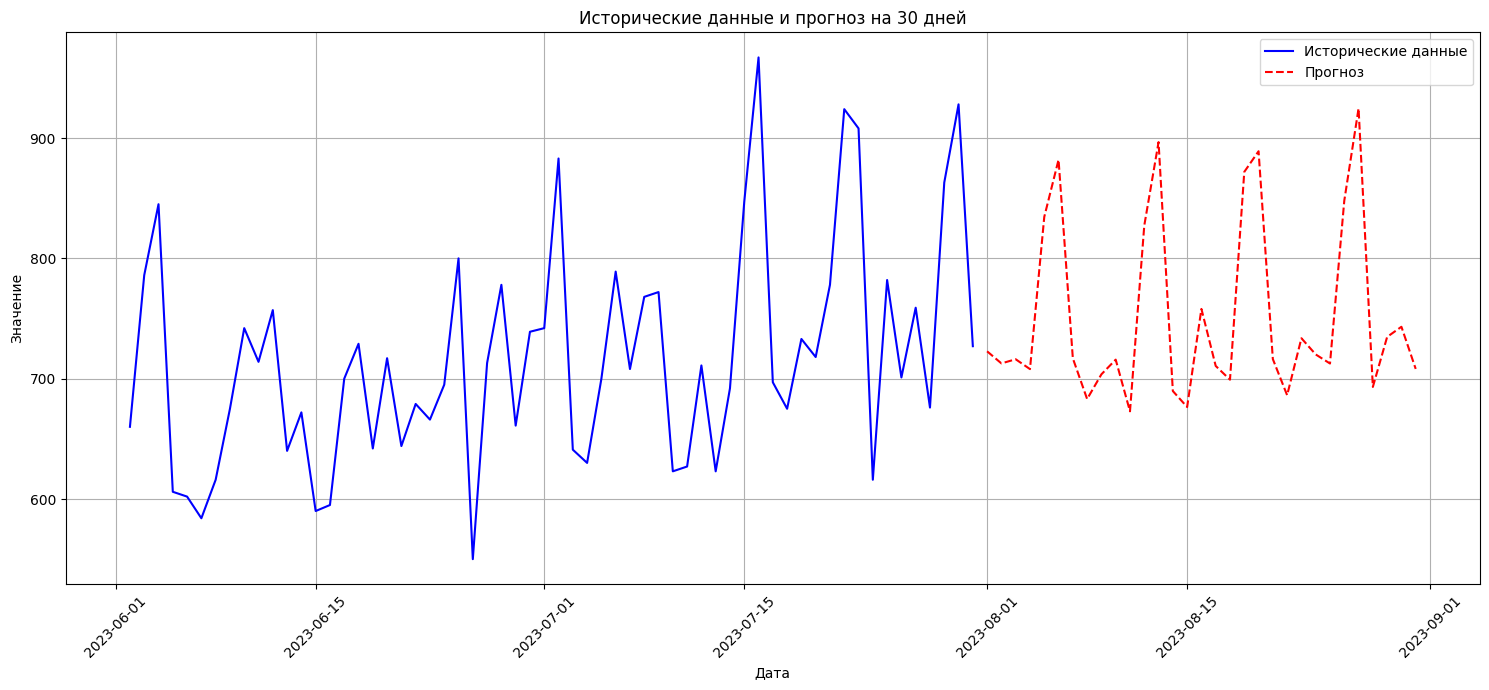

In [36]:
def predict_future_moirai(data, pdt):
    # Параметры модели
    SIZE = "base"  
    PDT = pdt  # длина предсказания (30 дней)
    CTX = 100  # длина контекста
    BSZ = 32 

    # Подготовка данных
    df = data.copy()
    ds = PandasDataset(dict(df))

    # Загрузка модели
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

    # Создание предиктора
    predictor = model.create_predictor(batch_size=BSZ)

    # Выполнение предсказаний
    forecasts = predictor.predict(ds)
    forecast = next(iter(forecasts))
    
    # Получаем предсказанные значения
    predicted_values = forecast.mean
    
    # Создаем даты для предсказанных значений
    last_date = pd.to_datetime(df.index[-1])
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=PDT, freq='D')
    
    # Создаем DataFrame с предсказаниями
    predictions_df = pd.DataFrame({
        'date': future_dates,
        'predicted_value': predicted_values
    })
    
    # Визуализация
    plt.figure(figsize=(15, 7))
    plt.plot(pd.to_datetime(df.index[-60:]), df['target'][-60:], label='Исторические данные', color='blue')
    plt.plot(predictions_df['date'], predictions_df['predicted_value'], label='Прогноз', color='red', linestyle='--')
    plt.title('Исторические данные и прогноз на 30 дней')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predictions_df

# Применяем функцию к каждому датасету
future_predictions = {}
pdt = [30, 30, 30, 31, 31]
for i in range(1, 6):
    data = eval(f'data{i}')
    print(f'\nПрогноз для датасета {i}:')
    future_predictions[f'dataset_{i}'] = predict_future_moirai(data, pdt[i-1])

Предсказание на 2 модели

In [37]:
#создадим функцию предобработки данных
def preprocess_data_predict_with_holidays_and_nearby(data):
    # Преобразуем дату
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)

    train = data

    last_date = data.index.max()  # Предполагается, что индекс — это даты
    next_month_start = (last_date + pd.offsets.MonthBegin(1)).date()
    next_month_end = (next_month_start + pd.offsets.MonthEnd(0)).date()

    # Генерация временных меток для следующего месяца
    next_month_dates = pd.date_range(next_month_start, next_month_end, freq='D')

    next_month_features = pd.DataFrame(index=next_month_dates)

    # День недели, месяц
    data['day_of_week'] = data.index.dayofweek  # Понедельник=0, Воскресенье=6
    data['month'] = data.index.month

    data['season'] = data['month'].apply(lambda x: 'winter' if x in [12, 1, 2]
                                         else 'spring' if x in [3, 4, 5]
                                         else 'summer' if x in [6, 7, 8]
                                         else 'autumn')
    
    next_month_features['day_of_week'] = next_month_features.index.dayofweek  # Понедельник=0, Воскресенье=6
    next_month_features['month'] = next_month_features.index.month

    next_month_features['season'] = next_month_features['month'].apply(lambda x: 'winter' if x in [12, 1, 2]
                                         else 'spring' if x in [3, 4, 5]
                                         else 'summer' if x in [6, 7, 8]
                                         else 'autumn')

    # Преобразование времени года в числовой формат
    season_mapping = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}
    data['season'] = data['season'].map(season_mapping)
    next_month_features['season'] = next_month_features['season'].map(season_mapping)

    # Является ли день выходным (суббота, воскресенье)
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)  # Суббота и Воскресенье
    next_month_features['is_weekend'] = next_month_features['day_of_week'].isin([5, 6]).astype(int)

    # === Добавление праздников ===
    cal = Russia()  # Российский календарь
    years = data.index.year.unique().tolist()  # Уникальные годы из данных
    holiday_dates = []

    # Получаем список всех праздников по годам
    for year in years:
        holiday_dates.extend(cal.holidays(year))  # Добавляем праздники для каждого года

    # Преобразуем праздники в DataFrame
    holiday_dates = pd.DataFrame(holiday_dates, columns=['date', 'holiday_name'])
    holiday_dates['date'] = pd.to_datetime(holiday_dates['date'])

    # Добавляем ±2 дня к каждому празднику
    extended_holiday_dates = []
    for holiday_date in holiday_dates['date']:
        for offset in range(-2, 3):  # от -2 до +2 включительно
            extended_holiday_dates.append(holiday_date + timedelta(days=offset))

    # Убираем дубликаты и сортируем
    extended_holiday_dates = sorted(set(extended_holiday_dates))

    # Добавляем признак "праздник или около праздника"
    data['is_holiday_or_near'] = data.index.isin(extended_holiday_dates).astype(int)
    next_month_features['is_holiday_or_near'] = next_month_features.index.isin(extended_holiday_dates).astype(int)

    # Учитываем праздники в выходных
    data['is_weekend_or_holiday'] = ((data['is_weekend'] == 1) | (data['is_holiday_or_near'] == 1)).astype(int)
    next_month_features['is_weekend_or_holiday'] = ((next_month_features['is_weekend'] == 1) | (next_month_features['is_holiday_or_near'] == 1)).astype(int)
    
    # Лаги (значения на предыдущих шагах)
    for lag in range(1, 8):  # Создаем лаги за последние 7 дней
        data[f'lag_{lag}'] = data['value'].shift(lag)

    for lag in range(1, 8):  # Создаем лаги за последние 7 дней
        data[f'lag_{lag}'] = data[f'lag_{lag}'].replace(0, data[f'lag_{lag}'].mean())

    # Скользящее среднее
    data['rolling_mean_7'] = data['value'].rolling(window=7).mean()
    data['rolling_mean_30'] = data['value'].rolling(window=30).mean()

    # Удаляем строки с пропусками, возникшими из-за лагов
    data = data.dropna()

    X_train, y_train = data.drop(columns=['value', 'is_holiday_or_near', 'is_weekend', 'month']), data['value']
    X_test = next_month_features.drop(columns=['is_holiday_or_near', 'is_weekend', 'month'])

    return X_train, X_test, y_train, X_test.index

In [38]:
#создадим функцию предобработки данных
def preprocess_data_predict_with_holidays_and_nearby(data):
    # Преобразуем дату
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)

    last_date = data.index.max()  # Предполагается, что индекс — это даты
    next_month_start = (last_date + pd.offsets.MonthBegin(1)).date()
    next_month_end = (next_month_start + pd.offsets.MonthEnd(0)).date()

    # Генерация временных меток для следующего месяца
    next_month_dates = pd.date_range(next_month_start, next_month_end, freq='D')

    next_month_features = pd.DataFrame(index=next_month_dates)

    # День недели, месяц
    data['day_of_week'] = data.index.dayofweek  # Понедельник=0, Воскресенье=6
    data['month'] = data.index.month

    
    data['season'] = data['month'].apply(lambda x: 1 if x in [12, 1, 2]
                                         else 2 if x in [3, 4, 5]
                                         else 3 if x in [6, 7, 8]
                                         else 4)
    
    data['is_weekend'] = data.index.to_series().apply(lambda x: 1 if x.date() in weekends else 0)
    
    next_month_features['day_of_week'] = next_month_features.index.dayofweek  # Понедельник=0, Воскресенье=6
    next_month_features['month'] = next_month_features.index.month

    next_month_features['season'] = next_month_features['month'].apply(lambda x: 1 if x in [12, 1, 2]
                                         else 2 if x in [3, 4, 5]
                                         else 3 if x in [6, 7, 8]
                                         else 4)

    # Является ли день выходным (суббота, воскресенье)
    data['is_weekend'] = data.index.to_series().apply(lambda x: 1 if x.date() in weekends else 0)
    next_month_features['is_weekend'] = next_month_features.index.to_series().apply(lambda x: 1 if x.date() in weekends else 0)
 
    
    data['is_holiday'] = data.index.to_series().apply(lambda x: 1 if x.date() in holidays else 0)
    next_month_features['is_holiday'] = next_month_features.index.to_series().apply(lambda x: 1 if x.date() in holidays else 0)

    # Лаги (значения на предыдущих шагах)
    for lag in range(1, 8):  # Создаем лаги за последние 7 дней
        data[f'lag_{lag}'] = data['value'].shift(lag)

    for lag in range(1, 8):  # Создаем лаги за последние 7 дней
        data[f'lag_{lag}'] = data[f'lag_{lag}'].replace(0, data[f'lag_{lag}'].mean())

    # Скользящее среднее
    data['rolling_mean_7'] = data['value'].rolling(window=7).mean()
    data['rolling_mean_30'] = data['value'].rolling(window=30).mean()

    # Удаляем строки с пропусками, возникшими из-за лагов
    data = data.dropna()

    X_train, y_train = data.drop(columns=['value', 'is_weekend', 'month']), data['value']
    X_test = next_month_features.drop(columns=['is_weekend', 'month'])
    print(X_test.columns, X_train.columns)
    return X_train, X_test, y_train, X_test.index

In [39]:
def train_predict_randomized_search(data):
    param_dist = {
        'n_estimators': [100, 250, 500, 1000],  # Количество деревьев
        'learning_rate': [0.01, 0.025, 0.05, 0.1],  # Скорость обучения
        'max_depth': [3, 5, 7],  # Глубина деревьев
        'num_leaves': [20, 31, 40, 50],  # Количество листьев в дереве
        'subsample': np.linspace(0.6, 1.0, 5),  # Часть выборки для каждого дерева
        'colsample_bytree': np.linspace(0.6, 1.0, 5),  # Часть признаков для каждого дерева
    }
    
    # Модель LightGBM
    model = lgb.LGBMRegressor(random_state=42)
    
    #RandomizedSearchCV с кросс-валидацией
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=60,  # Количество случайных комбинаций для поиска
        cv=5,  # 4-кратная кросс-валидация
        scoring='neg_mean_squared_error',  # Оценка по метрике MSE
        verbose=1,  # Вывод информации о процессе
        n_jobs=-1,  # Использование всех ядер процессора
        random_state=42
    )
    
    X_train, X_test, y_train, dates = preprocess_data_predict_with_holidays_and_nearby(data)
    print(1)
    # Обучение модели
    random_search.fit(X_train.to_numpy(), y_train.to_numpy())
    print(2)
    
    # Использование модели с лучшими параметрами
    best_model = random_search.best_estimator_
    print(3)
    
    # История состоит из y_train
    history = y_train.tolist()
    print(4)
    
    # Пошаговое предсказание
    print(5)
    y_pred = stepwise_prediction_lgb(best_model, X_test, history, lag_range=7)
    print(y_pred)
    clear_output(wait=True)

    print('Best params:', random_search.best_params_)

    feature_importances = best_model.feature_importances_

    feature_names = [f"Feature {i}" for i in range(12)]

    # Построение графика
    plt.barh(feature_names, feature_importances)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Feature Importances")
    plt.show()
    
    next_month_df = pd.DataFrame({
        'date': dates,  # Индекс со сгенерированными датами
        'prediction': y_pred       # Предсказанные значения
    })
    return next_month_df

Считываем снова чистые данные

In [40]:
data1 = pd.read_csv(path + 'data1.csv')
data2 = pd.read_csv(path + 'data2.csv')
data3 = pd.read_csv(path + 'data3.csv')
data4 = pd.read_csv(path + 'data4.csv')
data5 = pd.read_csv(path + 'data5.csv')

Предсказываем

Best params: {'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


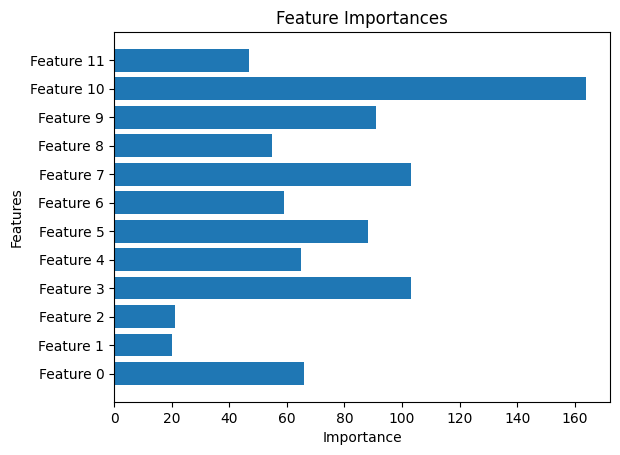

In [41]:
next_month_df1 = train_predict_randomized_search(data1)
next_month_df2 = train_predict_randomized_search(data2)
next_month_df3 = train_predict_randomized_search(data3)
next_month_df4 = train_predict_randomized_search(data4)
next_month_df5 = train_predict_randomized_search(data5)

In [42]:
# Получаем предсказания из второй модели (LightGBM)
next_month_predictions = {
    'dataset_1': next_month_df1,
    'dataset_2': next_month_df2,
    'dataset_3': next_month_df3,
    'dataset_4': next_month_df4,
    'dataset_5': next_month_df5
}

# Усредняем предсказания
for i in range(1, 6):
    dataset_key = f'dataset_{i}'
    
    # Получаем предсказания обеих моделей
    moirai_pred = future_predictions[dataset_key]['predicted_value']
    lgb_pred = next_month_predictions[dataset_key]['prediction']
    
    # Вычисляем среднее
    averaged_predictions = (moirai_pred + lgb_pred) / 2
    
    # Сохраняем усредненные предсказания в DataFrame
    next_month_predictions[dataset_key]['prediction'] = averaged_predictions

    print(f"Датасет {i} - усреднение выполнено")

Датасет 1 - усреднение выполнено
Датасет 2 - усреднение выполнено
Датасет 3 - усреднение выполнено
Датасет 4 - усреднение выполнено
Датасет 5 - усреднение выполнено


In [43]:
# Сохраняем предсказания в отдельные CSV файлы
for i in range(1, 6):
    dataset_key = f'dataset_{i}'
    
    # Создаем копию DataFrame с предсказаниями
    predictions_df = next_month_predictions[dataset_key].copy()
    
    # Переименовываем столбцы в соответствии с требуемым форматом
    predictions_df.columns = ['date', 'value']
    
    # Сохраняем в CSV
    output_path = f'{path}prediction{i}.csv'
    predictions_df.to_csv(output_path, index=False)
    
    print(f"Предсказания для датасета {i} сохранены в {output_path}")

Предсказания для датасета 1 сохранены в data/prediction1.csv
Предсказания для датасета 2 сохранены в data/prediction2.csv
Предсказания для датасета 3 сохранены в data/prediction3.csv
Предсказания для датасета 4 сохранены в data/prediction4.csv
Предсказания для датасета 5 сохранены в data/prediction5.csv


In [44]:
data1 =  pd.read_csv(path + 'prediction1.csv')
data2 = pd.read_csv(path + 'prediction2.csv')
data3 = pd.read_csv(path + 'prediction3.csv')
data4 = pd.read_csv(path + 'prediction4.csv')
data5 = pd.read_csv(path + 'prediction5.csv')


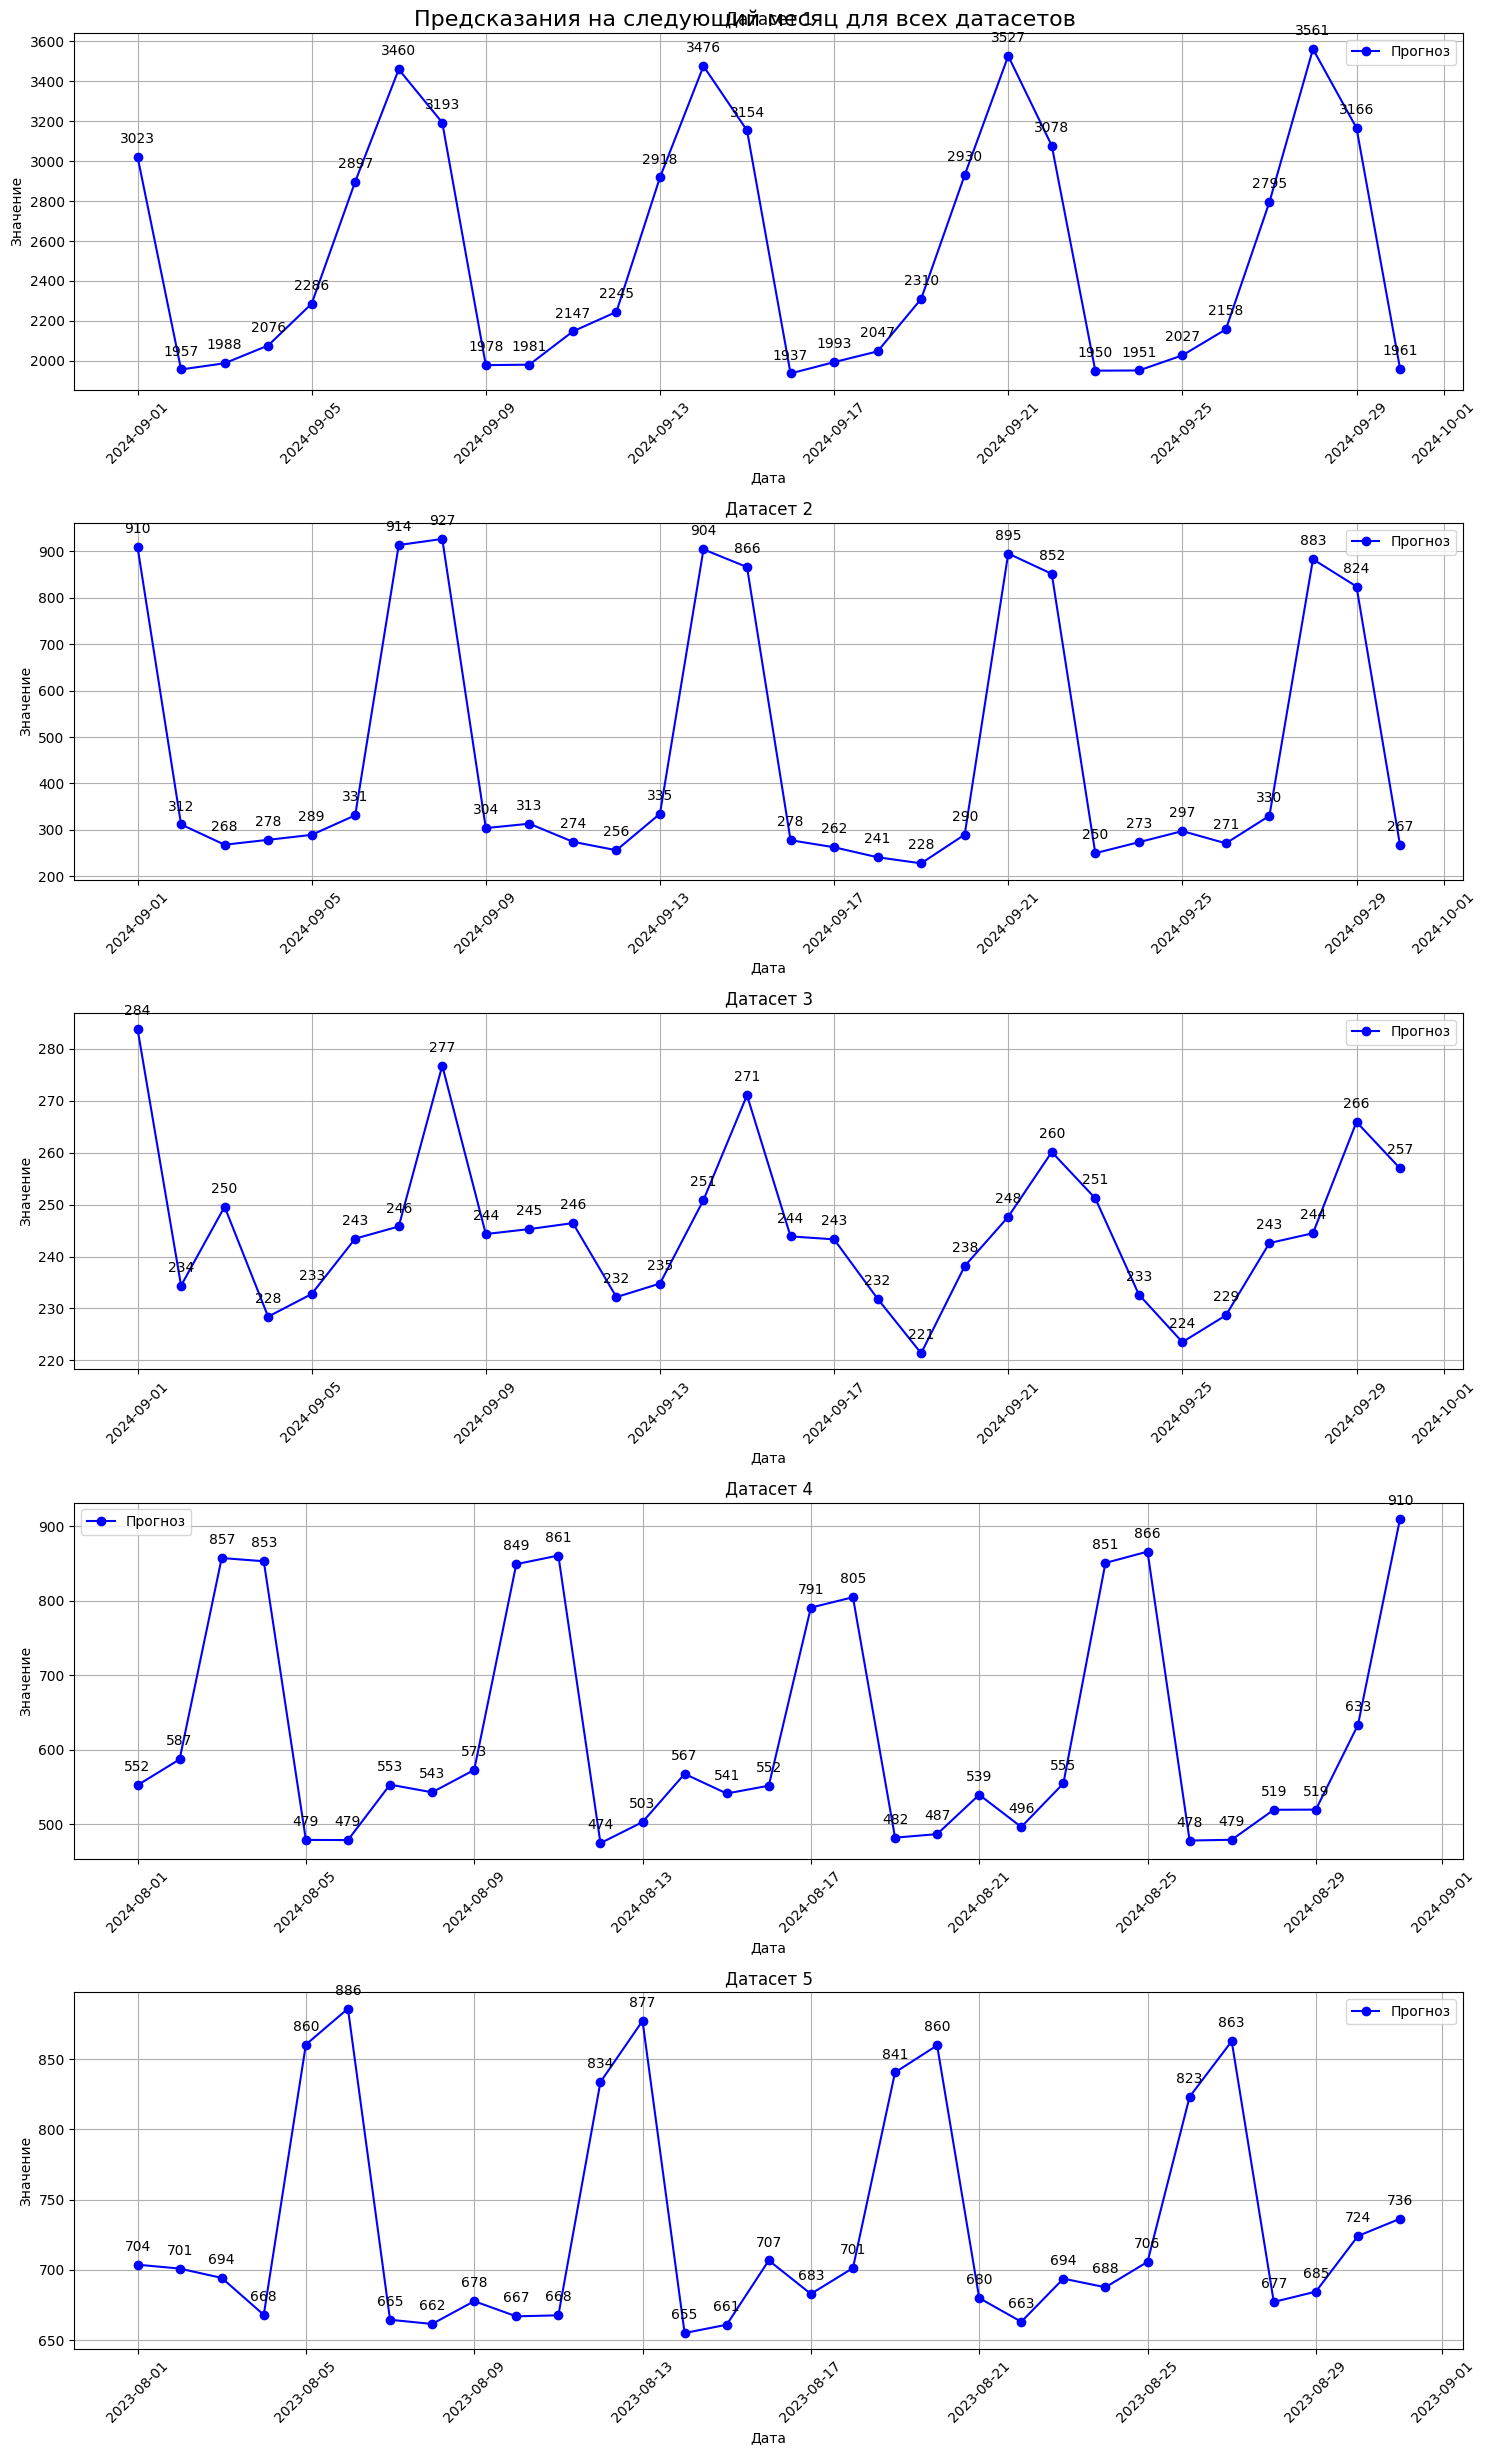


Статистика предсказаний для датасета 1:
Минимальное значение: 1936.65
Максимальное значение: 3561.46
Среднее значение: 2539.02
Медианное значение: 2265.56
--------------------------------------------------

Статистика предсказаний для датасета 2:
Минимальное значение: 227.83
Максимальное значение: 926.94
Среднее значение: 464.13
Медианное значение: 300.54
--------------------------------------------------

Статистика предсказаний для датасета 3:
Минимальное значение: 221.38
Максимальное значение: 283.83
Среднее значение: 245.08
Медианное значение: 244.10
--------------------------------------------------

Статистика предсказаний для датасета 4:
Минимальное значение: 474.48
Максимальное значение: 909.98
Среднее значение: 620.38
Медианное значение: 552.31
--------------------------------------------------

Статистика предсказаний для датасета 5:
Минимальное значение: 655.07
Максимальное значение: 885.89
Среднее значение: 729.29
Медианное значение: 694.30
--------------------------------

In [45]:
# Создаем фигуру с подграфиками
fig, axes = plt.subplots(5, 1, figsize=(15, 25))
fig.suptitle('Предсказания на следующий месяц для всех датасетов', fontsize=16)

for i in range(1, 6):
    ax = axes[i-1]
    
    # Получаем данные предсказаний
    predictions = eval(f'data{i}')
    predictions['date'] = pd.to_datetime(predictions['date'])
    
    # Строим график предсказаний
    ax.plot(predictions['date'], 
            predictions['value'], 
            label='Прогноз', 
            color='blue', 
            marker='o')
    
    # Настройка графика
    ax.set_title(f'Датасет {i}')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Значение')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)
    
    # Добавляем значения на график
    for x, y in zip(predictions['date'], predictions['value']):
        ax.annotate(f'{y:.0f}', 
                   (x, y), 
                   textcoords="offset points", 
                   xytext=(0,10), 
                   ha='center')

plt.tight_layout()
plt.show()

# Выводим статистику по предсказаниям
for i in range(1, 6):
    predictions = eval(f'data{i}')
    
    print(f"\nСтатистика предсказаний для датасета {i}:")
    print(f"Минимальное значение: {predictions['value'].min():.2f}")
    print(f"Максимальное значение: {predictions['value'].max():.2f}")
    print(f"Среднее значение: {predictions['value'].mean():.2f}")
    print(f"Медианное значение: {predictions['value'].median():.2f}")
    print("-" * 50)